# Train a Triplet Model with Data Iterations

## Table of Contents
* [Overview](#Overview)
* [Set the Environment](#Set-the-environment)
* [Build a Triplet Model](#Build-triplet-model)
* [Train the Model](#Train-the-model)
* [Test the Model](#Test-the-model)
* [Deploy the Model](#Deploy-the-model)
* [Test the ASTORE Model](#Test-astore-model)
* [Conclusion](#Conclusion)

## Overview <a id="Overview"></a>

This example shows how to train a Triplet Network without explicitly creating an ImageEmbeddingTable for training. Instead, the training data is created on-the-fly during training from a CAS-accessible directory. We then show how to save and deploy a branch of the network in ASTORE and use it as an embedding model. We evaluate the results with K-means clustering.

The data used for this example consists of a subset of images obtained from [Google's Open Image V4](https://arxiv.org/abs/1811.00982). To recreate this data set:

## Set the Environment <a id="Set-the-environment"></a>

First, set notebook environement by doing the following:
1. Import relevant modules
2. Use matplotlib inline magic so plots render correctly
3. Start a CAS session

<span style="color: red"> Remember: </span> Change `host_name` and `port_number` to match your CAS server. You should also have an authinfo (authentication) file set up as well.

In [1]:
from swat import *
from pprint import pprint

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 500)

In [3]:
from dlpy.layers import * 
from dlpy.applications import *
from dlpy import Model, Sequential
from dlpy.utils import *
from dlpy.splitting import two_way_split
from dlpy.lr_scheduler import *
from dlpy.images import *
from dlpy.image_embedding import *
from dlpy.embedding_model import EmbeddingModel

In [4]:
s = CAS('hostname', port_number)
s.sessionprop.setsessopt(caslib='CASUSER', timeout=31535000)

NOTE: 'CASUSER(userid)' is now the active caslib.


+ Elapsed: 0.000197s, user: 0.000119s, sys: 6.1e-05s, mem: 0.256mb

## Build a Triplet Model <a id="Build-triplet-model"></a>
A Triplet Network uses three copies of a neural network to learn discriminative features. We use ResNet18 as a base network for these three copies. Likewise, ResNet18 will serve as the base of our embedding, but in order to customize the embedding output, we add an embedding layer to ResNet18 that is also copied. 

We define our embedding layer to be a dense 4-neuron layer with an identity activation function. If this is not given, the last layer before the output layer will be used as the embedding layer.

The output features from each network are fed into an embedding loss layer to compute the triplet loss function. The triplet loss function is designed to minimize the Euclidean distance between the anchor image and the positive image and increase the distance between the anchor image and the negative image. Margin is used to tune how discriminative the features should be.

The resulting Triplet Network structure is stored in memory as the table "test_tr".

In [5]:
resnet18_model = ResNet18_Caffe(s,
                                width=224,
                                height=224
                                )

NOTE: Input layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Pooling layer added.
NOTE: Pooling layer added.
NOTE: Output layer added.
NOTE: Model compiled successfully.


In [6]:
embedding_layer = Dense(n=4, act='identity')
model_tr = EmbeddingModel.build_embedding_model(resnet18_model, model_table='test_tr',
                                              embedding_model_type='triplet', margin=-3.0,
                                              embedding_layer=embedding_layer)

NOTE: Convert the branch model into a functional model.
NOTE: Remove the task layers from the model.
NOTE: Model compiled successfully.


## Train the model <a id="Train-the-model"></a>
Generally, before training, we would need to create a training data set. We could do this easily with DLPy's ImageEmbeddingTable API or we could invoke CAS actions to craft the table manually as in <a href="https://go.documentation.sas.com/?docsetId=casdlpg&docsetTarget=p0rtwwco6lyoxhn1t2122nh99ldu.htm&docsetVersion=8.5&locale=en#p1ek9mpk0ctu4en1ez1yi52co425">the SAS documentation</a>. 

However, in this example, we avoid explicitly creating a training data set. Instead, we provide *model_tr.fit_embedding_model()* with a path to our training image directory. When we provide a path, we direct the fitting algorithm to create training data on-the-fly using images in the direcory. For the Triplet Network, each sample needs an anchor image, a positive image, a negative image, and all the data associated with each image (such as filename, label, size, etc.).

We begin by specifying a few standard training options such as our GPU devices and our optimizer. The training proceeds as follows:

1. Create a batch of `n_samples` samples.
2. Train on that batch for `max_epochs` epochs.
3. Repeat 1, 2 for `max_iter` iterations.

This returns a list containing a CASResult for each data iteration. You can use this list to investigate training history. Furthermore, a table called test_tr_weights is created in CAS to store the model weights.

In [7]:
from dlpy.model import Gpu
gpu = Gpu(devices=1)

In [8]:
from dlpy.model import Optimizer, MomentumSolver, AdamSolver
solver = AdamSolver(lr_scheduler=StepLR(learning_rate=0.0001, step_size=4), clip_grad_max = 100, clip_grad_min = -100)
optimizer = Optimizer(algorithm=solver, mini_batch_size=8, log_level=2, max_epochs=8, reg_l2=0.0001)

The following argument(s) learning_rate, learning_rate_policy, gamma, step_size, power are overwritten by the according arguments specified in lr_scheduler.


In [9]:
res = model_tr.fit_embedding_model(optimizer=optimizer, n_threads=4, gpu=gpu, seed=1234,record_seed=23435,
                                   path='/server-side/path/to/dog/data', n_samples=128, max_iter=15, 
                                   resize_width=224, resize_height=224)

Note: data generation took 2.0301365852355957 (s) at iteration 0
NOTE: Training from scratch.
NOTE: Using cloud.example.com: 1 out of 2 available GPU devices.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 33548364.
NOTE:  The approximate memory cost is 885.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       4.23 (s).
NOTE:  The total number of threads on each worker is 4.
NOTE:  The total mini-batch size per thread on each worker is 8.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 32.
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  0        0.0001         -0.1085      3.254     5.44
NOTE:  1        0.0001         -0.6286      4.011     0.67
NOTE:  2        0.0001         -0.8386       3.91     0.67
NOTE:  3        0.0001          -1.142      4.114     0.67
NOTE:  4          1E-5          -1.673      5.801     0.67
NOTE:  5          1E-5          -1.515      5.8

In [10]:
res[-1]

,Descr,Value
0,Model Name,test_tr
1,Model Type,Convolutional Neural Network
2,Number of Layers,163
3,Number of Input Layers,3
4,Number of Output Layers,0
5,Number of Convolutional Layers,63
6,Number of Pooling Layers,6
7,Number of Fully Connected Layers,3
8,Number of Batch Normalization Layers,63
9,Number of Residual Layers,24


## Test the model <a id="Test-the-model"></a>
Before exporting the model to ASTORE, we will test it first. Here we take advantage of the ImageEmbeddingTable API in order to create a testing data set. Because each dog is in it's corresponding dog breed category, we specify `label_level=-2` in order to generate labels from an image's immediate parent directory. 

We test the model on the created ImageEmbeddingTable and check the proportion of correctly classified images.

Remember, however, that the Triplet Network is really three identical networks whose output feeds into a single embedding loss layer. And, the testing data consists of three images, an anchor, a positive image, and a negative image. Because of this strange arrangement, we need to reconsider how scoring works.

When a Triplet Model is scored, two variables \_DL_Pred0\_ and \_DL_Pred1\_ are calculated. The first contains the distance between the anchor image feature and the positive image feature. The second contains the distance between the anchor image feature and the negative image feature. In order for a prediction to be considered a success, we require the anchor image to be closer to the positive image than to the negative image. Thus, \_DL_Pred0\_ < \_DL_Pred1_. We can then calculate the proportion of successful predictions.

In [11]:
my_table_test= ImageEmbeddingTable.load_files(s, path='/server-side/path/to/dog/test/data', 
                                             embedding_model_type='triplet', label_level=-2, 
                                             resize_width=224, resize_height=224)

In [12]:
out = model_tr.predict(data=my_table_test)

In [13]:
tot_obs = s.numrows(table=dict(name=model_tr.valid_res_tbl.name))
correctly_ranked_obs = s.numrows(table=dict(name=model_tr.valid_res_tbl.name, where='_DL_Pred0_ < _DL_Pred1_'))

In [14]:
correctly_ranked_obs['numrows']/tot_obs['numrows']

0.96875

## Deploy the model <a id="Deploy-the-model"></a>
We built, trained, and scored the Triplet Network as three identical networks combined by an embedding loss layer. However, in practice, we want to be able to use the embedding model on a single image. To save only one branch of the model to ASTORE, we specify `model_type='branch'`. The embedding loss layer is removed and replaced by a generic output layer. Alternatively, if we did want to store the Triplet Network as a whole, we could specify `model_type='full'`.

The generated ASTORE file will be stored on the client as specified by `path`.

Note that even this branch model isn't quite a classification model. Though we create an embedding, the output layer isn't configured to produce anything useful. It merely outputs the features from the embedding layer. In our case, the embedding layer is densely connected and outputs four numbers. To make this a true classification model, replace the final output layer with a layer capable of classifying, like softmax.

In [15]:
branch_model = model_tr.deploy_embedding_model(output_format='astore', model_type='branch', 
                                path=r'/client-side/path/to/astore/store')

NOTE: Model compiled successfully.
NOTE: Model weights attached successfully!
NOTE: Model astore file saved successfully.


In [16]:
branch_model.print_summary()

,Layer Id,Layer,Type,Kernel Size,Stride,Activation,Output Size,Number of Parameters,FLOPS(forward pass)
0,0,InputLayer_0,input,,,None,"(224, 224, 3)","(0, 0)",0
1,1,Convo.1,convo,"(7, 7)","(2, 2)",Identity,"(112, 112, 64)","(9408, 0)",118013952
2,2,B.N.1,batchnorm,,,Relu,"(112, 112, 64)","(0, 128)",0
3,3,Pool1,pool,"(3, 3)","(2, 2)",Max,"(56, 56, 64)","(0, 0)",0
4,4,R1C2,convo,"(3, 3)","(1, 1)",Identity,"(56, 56, 64)","(36864, 0)",115605504
5,5,R1B2,batchnorm,,,Relu,"(56, 56, 64)","(0, 128)",0
6,6,R1C3,convo,"(3, 3)","(1, 1)",Identity,"(56, 56, 64)","(36864, 0)",115605504
7,7,R1B3,batchnorm,,,Relu,"(56, 56, 64)","(0, 128)",0
8,8,R1C0,convo,"(1, 1)","(1, 1)",Identity,"(56, 56, 64)","(4096, 0)",12845056
9,9,R1B0,batchnorm,,,Identity,"(56, 56, 64)","(0, 128)",0


## Test the ASTORE Model <a id="Test-astore-model"></a>
Now that we have an embedding model with a single branch, we can verify our results with a single image stream. If our embedding works well then we should have 6 clusters - one for each dog breed in our data set.

First we load the ASTORE Model.
Then we check the ASTORE information, noting that \_LayerAct_53_0_0_0 through \_LayerAct_53_0_0_3 are the components of the embedding vector. Instead of creating a new testing data set, we use the first image column from the previous test data set. Using `astore.score`, we compute an embedding vector for each image and use the embedding vectors for K-means clustering. 

In [17]:
with open(r'/client-side/path/to/stored/model', mode='rb') as file: 
    fileContent = file.read()   
s.loadactionset('astore')
store_ = sw.blob(fileContent)
s.astore.upload(rstore=dict(name='test_tr_branch', replace=True),store = store_)

NOTE: Added action set 'astore'.
NOTE: 44793765 bytes were uploaded to the table "test_tr_branch" in the caslib "CASUSER(userid)".


+ Elapsed: 0.064s, user: 0.0237s, sys: 0.0402s, mem: 87mb

In [18]:
s.astore.describe(rstore='test_tr_branch')

[Key]

 Store Key
 
                                         Key
 0  26DBD4EF5E92B34E4EA928A19DA933403DB7E0E2

[Description]

 Basic Information
 
          Attribute               Value
 0  Analytic Engine           deeplearn
 1     Time Created  25Feb2020:14:57:51

[InputVariables]

 Input Variables
 
       Name     Length   Role       Type    RawType FormatName
 0  _image_  1000000.0  Input  Varbinary  Character           

[OutputVariables]

 Output Variables
 
                   Name  Length       Type                              Label
 0      P__fake_output_     8.0        Num           Predicted: _fake_output_
 1      I__fake_output_    12.0  Character                Into: _fake_output_
 2  _LayerAct_53_0_0_0_     8.0        Num  Output for Layer embeddinglayer_0
 3  _LayerAct_53_0_0_1_     8.0        Num  Output for Layer embeddinglayer_0
 4  _LayerAct_53_0_0_2_     8.0        Num  Output for Layer embeddinglayer_0
 5  _LayerAct_53_0_0_3_     8.0        Num  Output for Layer embeddinglayer_0

+ Elapsed: 1.16s, user: 1.09s, sys: 0.0696s, mem: 197mb

In [19]:
my_table_one_image_col = ImageTable.from_table(my_table_test, path_col='_path_')

In [20]:
my_table_one_image_col.label_freq

,Level,Frequency
german_shepherd,1,79
golden_retriever,2,73
labrador_retriever,3,116
miniature_poodle,4,110
soft-coated_wheaten_terrier,5,73
toy_poodle,6,61


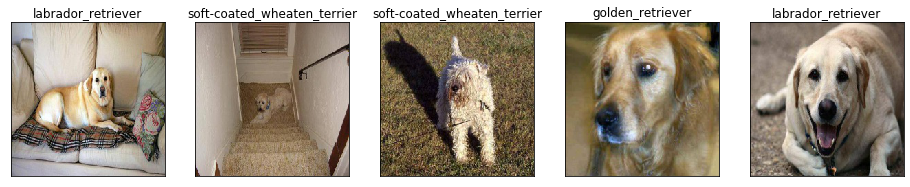

In [21]:
my_table_one_image_col.show()

In [22]:
s.score(rstore = 'test_tr_branch',
        table = my_table_one_image_col,
        nthreads =1,
        copyvars=['_filename_0', '_label_'],
        options=[dict(name='usegpu', value='1'),
                 dict(name='NDEVICES', value='1'), 
                 dict(name='DEVICE0', value='0')
                ],
        out = dict(name='astore_score1_branch_gpu', replace=True))

[OutputCasTables]

             casLib                      Name  Rows  Columns  \
 0  CASUSER(userid)  astore_score1_branch_gpu   512        8   
 
                                                          casTable  
 0  CASTable('astore_score1_branch_gpu', caslib='CASUSER(userid)')  

[Timing]

 Task Timing
 
                  Task   Seconds   Percent
 0   Loading the Store  0.000291  0.000068
 1  Creating the State  2.294689  0.533066
 2             Scoring  2.009527  0.466822
 3               Total  4.304696  1.000000

+ Elapsed: 4.89s, user: 3.57s, sys: 1.02s, mem: 285mb

In [23]:
s.fetch(table='astore_score1_branch_gpu', fetchVars=['_LayerAct_53_0_0_0_', '_LayerAct_53_0_0_0_', 
                                                     '_LayerAct_53_0_0_1_', '_LayerAct_53_0_0_2_'],
       to=5)

,_LayerAct_53_0_0_0_,_LayerAct_53_0_0_0_2,_LayerAct_53_0_0_1_,_LayerAct_53_0_0_2_
0,0.582717,0.582717,-0.580997,1.262640
1,0.360081,0.360081,-0.469913,3.432876
2,-0.860158,-0.860158,-0.901046,2.697191
3,-1.701389,-1.701389,-7.478656,3.968048
4,-0.308271,-0.308271,0.395658,0.821761


In [24]:
feature_list=[]
for i in range(0, 4):
    feature_list.append("_LayerAct_53_0_0_" + str(i) +"_")

In [25]:
s.loadactionset('clustering')
s.kclus(table=dict(name='astore_score1_branch_gpu'),
        maxClusters=6, maxIters=100, standardize='std',
        inputs=feature_list,
        output=dict(casout=dict(name='cluster_results', replace=True),
                   copyvars=['_filename_0', '_label_']))

NOTE: Added action set 'clustering'.
NOTE: Using SEED=26569517.
NOTE: Running for input data for K 6.
NOTE: Clustering is finished. STOPVALUE is satisfied for STOPCRITERION=CLUSTER_CHANGE.


[outputSize]

 {'outputNObs': 512.0, 'outputNVars': 5}

[NObs]

 Number of Observations
 
                           Type      N
 0  Number of Observations Read  512.0
 1  Number of Observations Used  512.0

[ModelInfo]

 Model Information
 
                              RowId                        Parameter  \
 0             Clustering_Algorithm             Clustering Algorithm   
 1               Maximum_Iterations               Maximum Iterations   
 2                   Stop_Criterion                   Stop Criterion   
 3             Stop_Criterion_Value             Stop Criterion Value   
 4                         Clusters                         Clusters   
 5                   Initialization                   Initialization   
 6                             Seed                             Seed   
 7  Distance_For_Interval_Variables  Distance for Interval Variables   
 8                  Standardization                  Standardization   
 9              Interval_Imputation              Interval Imputation   
 
           Setting  
 0         K-means  
 1             100  
 2  Cluster Change  
 3               0  
 4               6  
 5           Forgy  
 6        26569517  
 7       Euclidean  
 8             Std  
 9            None  

[DescStats]

 Descriptive Statistics
 
               Variable      Mean    StdDev
 0  _LayerAct_53_0_0_0_ -0.270455  1.446258
 1  _LayerAct_53_0_0_1_ -2.098239  2.732162
 2  _LayerAct_53_0_0_2_  0.116885  2.595751
 3  _LayerAct_53_0_0_3_ -0.216247  2.315740

[WithinClusStats]

 Within Cluster Statistics
 
                Variable  Cluster      Mean    StdDev
 0   _LayerAct_53_0_0_0_        1  0.154114  0.365863
 1                              2  0.354572  0.317748
 2                              3 -1.082023  0.369652
 3                              4 -0.065711  0.386649
 4                              5  0.820558  0.808843
 5                              6 -1.198610  0.830801
 6   _LayerAct_53_0_0_1_        1  0.983090  0.384363
 7                              2  1.109151  0.560094
 8                              3 -0.367316  0.336309
 9                              4  1.058853  0.331295
 10                             5 -0.349012  0.508111
 11                             6 -1.566378  0.317116
 12  _LayerAct_53_0_0_2_        1  0.912775  0.284786
 13                             2  0.578129  0.464220
 14                             3 -1.403251  0.314191
 15                             4  0.130134  0.288987
 16                             5 -0.615177  0.347038
 17                             6  1.600462  0.388978
 18  _LayerAct_53_0_0_3_        1  0.992052  0.308545
 19                             2 -0.187098  0.238929
 20                             3 -0.709927  0.454439
 21                             4 -1.495546  0.522422
 22                             5  0.604186  0.496226
 23                             6  0.453966  0.586886

[Standardization]

 Standardization
 
               Variable  Location     Scale
 0  _LayerAct_53_0_0_0_ -0.270455  1.446258
 1  _LayerAct_53_0_0_1_ -2.098239  2.732162
 2  _LayerAct_53_0_0_2_  0.116885  2.595751
 3  _LayerAct_53_0_0_3_ -0.216247  2.315740

[ClusterSum]

 Cluster Summary
 
    Cluster  Frequency   MinDist   MaxDist   AvgDist         SSE  StdDeviation  \
 0        1       61.0  0.217021  1.430621  0.612351   27.473631      0.671109   
 1        2       34.0  0.502547  1.028262  0.783452   22.679484      0.816727   
 2        3       68.0  0.205017  1.134856  0.663834   37.183498      0.739470   
 3        4       98.0  0.288418  1.263381  0.708147   59.722192      0.780647   
 4        5      178.0  0.394553  1.926018  1.071901  226.397106      1.127783   
 5        6       73.0  0.553377  2.201971  0.991728   92.630289      1.126458   
 
    NearestClus  DBtwCentroids  
 0          2.0       1.248381  
 1          1.0       1.248381  
 2          5.0       2.442970  
 3          2.0       1.446341  
 4          2.0       2.096065  
 5     

In [26]:
s.freq(table=dict(name='cluster_results', groupby='_cluster_id_'), inputs='_label_')

[ByGroupInfo]

 ByGroupInfo
 
    _CLUSTER_ID_ _CLUSTER_ID__f         _key_
 0           1.0              1             1
 1           2.0              2             2
 2           3.0              3             3
 3           4.0              4             4
 4           5.0              5             5
 5           6.0              6             6

[ByGroup1.Frequency]

 Frequency for CLUSTER_RESULTS
 
                Column                      CharVar  \
 _CLUSTER_ID_                                         
 1             _label_  soft-coated_wheaten_terrier   
 
                                    FmtVar  Level  Frequency  
 _CLUSTER_ID_                                                 
 1             soft-coated_wheaten_terrier      1       61.0  

[ByGroup2.Frequency]

 Frequency for CLUSTER_RESULTS
 
                Column                      CharVar  \
 _CLUSTER_ID_                                         
 2             _label_              german_shepherd   
 2             _label_           labrador_retriever   
 2             _label_  soft-coated_wheaten_terrier   
 
                                    FmtVar  Level  Frequency  
 _CLUSTER_ID_                                                 
 2                         german_shepherd      1        4.0  
 2                      labrador_retriever      2       18.0  
 2             soft-coated_wheaten_terrier      3       12.0  

[ByGroup3.Frequency]

 Frequency for CLUSTER_RESULTS
 
                Column           CharVar            FmtVar  Level  Frequency
 _CLUSTER_ID_                                                               
 3             _label_  miniature_poodle  miniature_poodle      1        7.0
 3             _label_        toy_poodle        toy_poodle      2       61.0

[ByGroup4.Frequency]

 Frequency for CLUSTER_RESULTS
 
                Column             CharVar              FmtVar  Level  \
 _CLUSTER_ID_                                                           
 4             _label_  labrador_retriever  labrador_retriever      1   
 
               Frequency  
 _CLUSTER_ID_             
 4                  98.0  

[ByGroup5.Frequency]

 Frequency for CLUSTER_RESULTS
 
                Column           CharVar            FmtVar  Level  Frequency
 _CLUSTER_ID_                                                               
 5             _label_   german_shepherd   german_shepherd      1       75.0
 5             _label_  miniature_poodle  miniature_poodle      2      103.0

[ByGroup6.Frequency]

 Frequency for CLUSTER_RESULTS
 
                Column           CharVar            FmtVar  Level  Frequency
 _CLUSTER_ID_                                                               
 6             _label_  golden_retriever  golden_retriever      1       73.0

+ Elapsed: 0.0081s, user: 0.00359s, sys: 0.00924s, mem: 8.66mb

## Conclusion <a id="Conclusion"></a>
We end up with 6 quite good clusters using a vector with 4 numbers. Each cluster is dominated by a single class. 

In [27]:
s.endsession()

+ Elapsed: 0.000113s, user: 9.1e-05s, sys: 1.1e-05s, mem: 0.205mb